# Microsoft Professional Capstone Project: IA

This notebook will be used as the main background for the Microsoft Professional Capstone for IA. All the code used to overcome this project will be shown here. The following lines contains a description of the problem we are trying to tackle.

### Problem Description

According to a 2017 report, the U.S. Energy Information Administration projects a 28% increase in world energy consumption by 2040. And the energy sector is a major contributor to climate change. For example, energy production and use accounts for more than 84% of U.S. greenhouse gas emissions.

Increasing the efficiency of energy consumption has benefits for consumers, providers, and the environment. With an increasing number of IoT devices coming online in the energy sector, there is more and more data that can be used to monitor and track energy consumption. Ultimately, this type of data can be used to provide consumers and businesses with recommendations on ways to save energy, lower costs, and help the planet.

##### In this challenge,  standard AI tools will be used to identify 11 different types of appliances from their electric signatures, quantified by current and voltage measurements.

### Background

This plug load dataset contains current and voltage measurements sampled at 30 kHz from 11 different appliance types present in more than 60 households in Pittsburgh, Pennsylvania. Plug load refers to the energy used by products that are powered by means of an ordinary AC plug (i.e., plugged into an outlet). For each appliance, plug load measurements were post-processed to extract a two-second-long window of measurements of current and voltage. For some observations, the window contains both the startup transient state (turning the appliance on) as well as the steady-state operation (once the appliance is running). For others, the window only contains the steady-state operation. The observations were then transformed into two spectrograms, one for current, and one for voltage.

A spectrogram is a visual representation of the various frequencies of sound as they vary with time. The x-axis represents time (2 seconds in our case), and the y-axis represents frequency (measured in Hz). The colors indicate the amplitude of a particular frequency at a particular time (i.e., how loud it is). We're measuring amplitude in decibels, with 0 being the loudest, and -80 being the softest. So in the example spectrogram below, lower frequencies are louder than higher frequencies. Our spectrograms tend to have horizontal lines given that we are capturing appliances in their steady-state. In other words, the amplitudes of various frequencies are fairly constant over time.

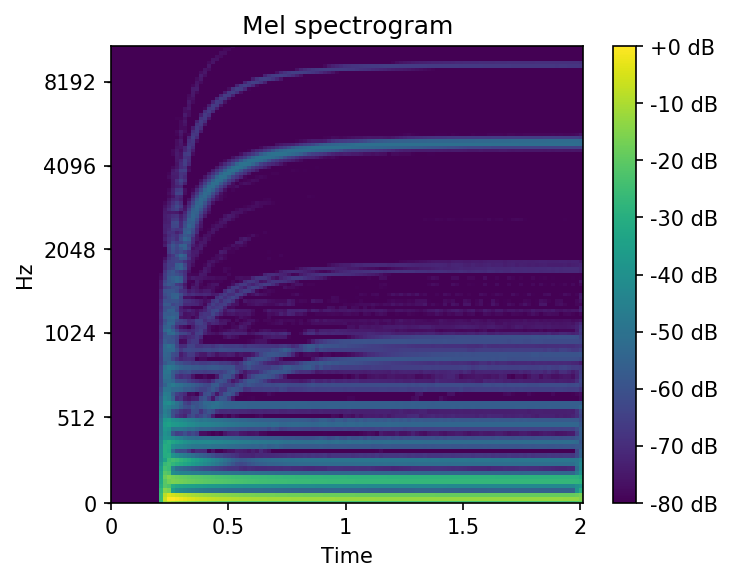

### Spectrograms

Spectrograms were created using librosa, a python package for music and audio analysis. The code to generate a spectrogram looks like this:

Under the hood, this process:

Takes the fourier transform of a windowed excerpt of the raw signal, in order to decompose the signal into its consistuent frequencies.

To learn more about fourier transforms, check out this awesome tutorial by 3Blue1Brown: But what is the Fourier Transform.
Maps the powers of the spectrum onto the mel scale. The mel scale is a perceptual scale where pitches are judged to be equal in distance from one another based on the human ear.
Takes the logs of the power (amplitude squared) at each of the mel frequencies to convert to decibel units.
Plots and saves the resulting image.

#### There is a lot of useful information encoded in these spectrograms. Now it's time to use deep learning to parse out which patterns correspond to which types of appliances.

### About the data

The goal is to predict types of appliances from spectrograms of current and voltage measurements. A spectrogram is a visual representation of the various frequencies of sound as they vary with time. These spectrograms were generated from current and voltage measurements sampled at 30 kHz from 11 different appliance types present in more than 60 households in Pittsburgh, Pennsylvania, USA. Data collection took place during the summer of 2013, and winter of 2014. Each appliance type is represented by dozens of different instances of varying make/models.

One folder of images is labeled train. You have the true labels for these images in train_labels.csv.
One folder of images is labeled test. You don't know the true labels for these.

The job is to:

Train a model using the images in train and the labels train_labels.csv
Predict appliance labels for the images in test for which you don't know the true appliances.

For each observation, a spectrogram is given, of current and a spectrogram of voltage. The files are therefore named with the conventions {id}_c.png and {id}_v.png, where _c corresponds to current and _v corresponds to voltage. The {id} in the filename matches the id column in train_labels.csv for the training data and in submission_format.csv for the test data.

#### Note that two images for each observation are given. To start, it might be necessary to first work with just the current OR the voltage files. Then, once you have a baseline model working, consider training a multi-channel network that can handle stacked inputs.

### Target Variable

The appliance labels correspond to the following appliances:

0: Compact Fluorescent Lamp
1: Hairdryer
2: Microwave
3: Air Conditioner
4: Fridge
5: Laptop
6: Vacuum
7: Incandescent Light Bulb
8: Fan
9: Washing Machine
10: Heater

### Performance Metric

To measure your model's performance by looking at prediction error, we'll use the simple classification rate accuracy metric (often referred to simply as "accuracy"). This is a quantity in [0,1] where a higher value is better, and is given by the following formula:

Classification Rate = Nº Correct/ Nº Predictions

classification rate(y^,y)=Ncorrect/Npredictions
In this case, Npredictions=659 because there are 659 rows in the test set.

In [1]:
from IPython.display import display, Image
import skimage
from __future__ import print_function # Use a function definition from future version (say 3.x from 2.7 interpreter)
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import time
import cntk as C
import gzip
import struct
import zipfile
import pathlib
import imageio
import numpy as np
import PIL

try: 
    from urllib.request import urlretrieve 
except ImportError: 
    from urllib import urlretrieve

%matplotlib inline

print("libraries imported!!")

libraries imported!!


In [2]:
# Select the right target device when this notebook is being tested:
if 'TEST_DEVICE' in os.environ:
    if os.environ['TEST_DEVICE'] == 'cpu':
        C.device.try_set_default_device(C.device.cpu())
    else:
        C.device.try_set_default_device(C.device.gpu(0))

In [3]:
# Test for CNTK version
if not C.__version__ == "2.6":
    raise Exception("this notebook is designed to work with 2.6. Current Version: " + C.__version__) 

In [43]:
# Ensure we always get the same amount of randomness
np.random.seed(0)
C.cntk_py.set_fixed_random_seed(1)
C.cntk_py.force_deterministic_algorithms()

# Define the data dimensions
input_dim_model = (1976, 15104)    # images are 128 x 118 with 1 channel of color (gray)
input_dim = 128*118                # used by readers to treat input data as a vector
num_output_classes = 11

### Data Collection

First we are going to process and convert the data to the appropiate format for CNTK

In [19]:
import numpy as np
import cv2
 
ID_APP_MAP_FILENAME = 'train_labels.csv'
IMAGE_PATH_FORMAT = 'Capstone data/train/%04d_%s.png'
 
def load_id_app_map(filename):
    result = {}
    with open(filename) as f:
        lines = f.read().splitlines()[1:]
        for line in lines:
            parts = list(map(int, line.split(',')))
            if len(list(parts)) == 2:
                result[parts[0]] = parts[1]
            elif len(parts) == 1: # no label
                result[parts[0]] = -1
 
    return result
   
def gen_label_array(label, label_count):
    label_flags = np.zeros(label_count, np.uint8)
    if label >= 0: # -1 signifies no label
        label_flags[label] = 1
    return label_flags
 
def load_flat_image(filename):
    image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise RuntimeError('Failed to load image "%s".' % filename)
    return image.flatten()
 
id_app_map = load_id_app_map(ID_APP_MAP_FILENAME)
 
label_count = np.max(list(id_app_map.values())) + 1
 
rows = []
for id,appliance in sorted(id_app_map.items()):
    labels = gen_label_array(appliance, label_count)
    flattened_c = load_flat_image(IMAGE_PATH_FORMAT % (id, 'c'))
    flattened_v = load_flat_image(IMAGE_PATH_FORMAT % (id, 'v'))
    rows.append(np.hstack([labels]))
    rows.append(np.hstack([labels]))
 
train_labels = np.vstack(rows)
 
print (train_labels.shape)

(1976, 11)


In [11]:
import numpy as np
import cv2
 
ID_APP_MAP_FILENAME = 'train_labels.csv'
IMAGE_PATH_FORMAT = 'Capstone data/train/%04d_%s.png'
 
def load_id_app_map(filename):
    result = {}
    with open(filename) as f:
        lines = f.read().splitlines()[1:]
        for line in lines:
            parts = list(map(int, line.split(',')))
            if len(parts) == 2:
                result[parts[0]] = parts[1]
            elif len(parts) == 1: # no label
                result[parts[0]] = -1
 
    return result
   
def gen_label_array(label, label_count):
    label_flags = np.zeros(label_count, np.uint8)
    if label >= 0: # -1 signifies no label
        label_flags[label] = 1
    return label_flags
 
def load_flat_image(filename):
    image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise RuntimeError('Failed to load image "%s".' % filename)
    return image.flatten()
 
id_app_map = load_id_app_map(ID_APP_MAP_FILENAME)
 
label_count = np.max(list(id_app_map.values())) + 1
 
rows = []
for id,appliance in sorted(id_app_map.items()):
    labels = gen_label_array(appliance, label_count)
    flattened_c = load_flat_image(IMAGE_PATH_FORMAT % (id, 'c'))
    flattened_v = load_flat_image(IMAGE_PATH_FORMAT % (id, 'v'))
    rows.append(np.hstack([ flattened_c]))
    rows.append(np.hstack([ flattened_v]))
 
train = np.vstack(rows)
 
print (train.shape)

(1976, 15104)


In [24]:
import numpy as np
import cv2
 
ID_APP_MAP_FILENAME = 'test_labels.csv'
IMAGE_PATH_FORMAT = 'Capstone data/test/%04d_%s.png'
 
def load_id_app_map(filename):
    result = {}
    with open(filename) as f:
        lines = f.read().splitlines()[1:]
        for line in lines:
            parts = list(map(int, line.split(',')))
            if len(parts) == 2:
                result[parts[0]] = parts[1]
            elif len(parts) == 1: # no label
                result[parts[0]] = -1
 
    return result
   
def gen_label_array(label, label_count):
    label_flags = np.zeros(label_count, np.uint8)
    if label >= 0: # -1 signifies no label
        label_flags[label] = 1
    return label_flags
 
def load_flat_image(filename):
    image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise RuntimeError('Failed to load image "%s".' % filename)
    return image.flatten()
 
id_app_map = load_id_app_map(ID_APP_MAP_FILENAME)
 
label_count = np.max(list(id_app_map.values())) + 1
 
rows = []
for id,appliance in sorted(id_app_map.items()):
    labels = gen_label_array(appliance, label_count)
    flattened_c = load_flat_image(IMAGE_PATH_FORMAT % (id, 'c'))
    flattened_v = load_flat_image(IMAGE_PATH_FORMAT % (id, 'v'))
    rows.append(np.hstack([ flattened_c]))
    rows.append(np.hstack([ flattened_v]))
 
test = np.vstack(rows)
 
print (train.shape)

(1976, 15104)


In [21]:
# Save the data files into a format compatible with CNTK text reader
def savetxt(filename, data, hasLabels=True, labels=0):
    dir = os.path.dirname(filename)

    if not os.path.exists(dir):
        os.makedirs(dir)
    
    print("Saving", filename )
    with open(filename, 'w') as f:
        print("opened....")
        labels_ohe = list(map(' '.join, np.eye(11, dtype=np.uint).astype(str))) #for one hot encoding
        index = 0
        for row in data:            
            row_str = row.astype(str)
            if hasLabels:                               
                label_str = labels_ohe[int(labels[index])]               
            
            feature_str = ' '.join(row_str)
            
            if hasLabels:
                f.write('|labels {} |features {}\n'.format(label_str, feature_str))
            else:
                f.write('|features {}\n'.format(feature_str))
            
            index = index + 1

In [25]:
train_labels_GT = train_labels[:,1] #Get Ground truth


print ('Writing train text file...')

data_dir = os.path.join(os.getcwd(), "Data/Out")


savetxt(os.path.join(data_dir, "train.txt"), train, True, train_labels_GT)
savetxt(os.path.join(data_dir, "test.txt"), test, False)


print("Done")

Writing train text file...
Saving C:\Users\bauer\OneDrive para la Empresa\Microsoft Capstone IA\Data/Out\train.txt
opened....
Saving C:\Users\bauer\OneDrive para la Empresa\Microsoft Capstone IA\Data/Out\test.txt
opened....
Done


# Ignore this

In [11]:
#Old Stuff, useful before, maybe useful again, but ignore by now

'''import pandas as pd
import numpy as np

train = pd.read_csv('C:/Users/A702628/OneDrive - Atos/Microsoft Capstone IA/MachineLearningSamples-ImageClassificationUsingCntk-master/MachineLearningSamples-ImageClassificationUsingCntk-master/train_array.csv', header = None)
test = pd.read_csv('C:/Users/A702628/OneDrive - Atos/Microsoft Capstone IA/MachineLearningSamples-ImageClassificationUsingCntk-master/MachineLearningSamples-ImageClassificationUsingCntk-master/test_array.csv', header = None)
train_labels = pd.read_csv('C:/Users/A702628/OneDrive - Atos/Microsoft Capstone IA/MachineLearningSamples-ImageClassificationUsingCntk-master/MachineLearningSamples-ImageClassificationUsingCntk-master/onehot_labels_array.csv', header = None)
train = train.values
test = test.values
train_labels = train_labels.values
print('Training set shape is: ', train.shape, '\n', 'Test set shape is: ', test.shape, '\n', 'The training labels se shape is: ', train_labels.shape)'''

Training set shape is:  (1976, 15104) 
 Test set shape is:  (1318, 15104) 
 The training labels se shape is:  (1976, 11)


In [39]:
# Read a CTF formatted text (as mentioned above) using the CTF deserializer from a file
def create_reader(path, is_training, input_dim, num_label_classes):
    
    ctf = C.io.CTFDeserializer(path, C.io.StreamDefs(
          labels=C.io.StreamDef(field='labels', shape=num_label_classes, is_sparse=False),
          features=C.io.StreamDef(field='features', shape=input_dim, is_sparse=False)))
                          
    return C.io.MinibatchSource(ctf,
        randomize = is_training, max_sweeps = C.io.INFINITELY_REPEAT if is_training else 1)

In [40]:
x = C.input_variable(input_dim_model)
y = C.input_variable(num_output_classes)

In [41]:
# function to build model

def create_model(features):
    with C.layers.default_options(init=C.glorot_uniform(), activation=C.relu):
            h = features
            h = C.layers.Convolution2D(filter_shape=(5,5), 
                                       num_filters=8, 
                                       strides=(2,2), 
                                       pad=True, name='first_conv')(h)
            h = C.layers.Convolution2D(filter_shape=(5,5), 
                                       num_filters=16, 
                                       strides=(2,2), 
                                       pad=True, name='second_conv')(h)
            r = C.layers.Dense(num_output_classes, activation=None, name='classify')(h)
            return r

In [42]:
# Create the model
z = create_model(x)

# Print the output shapes / parameters of different components
print("Output Shape of the first convolution layer:", z.first_conv.shape)
print("Bias value of the last dense layer:", z.classify.b.value)

ValueError: Convolution operation requires that kernel dim 5 <= input dim 1.

[CALL STACK]
    > std::enable_shared_from_this<Microsoft::MSR::CNTK::MatrixBase>::  shared_from_this
    - std::enable_shared_from_this<Microsoft::MSR::CNTK::MatrixBase>::  shared_from_this
    - CNTK::NDMask::  MaskedCount (x2)
    - CNTK::Internal::  Unsqueeze (x4)
    - CNTK::Function::  ReplacePlaceholders
    - CNTK::  ImageScaler
    - CNTK::Function::  ~Function
    - CNTK_ReleaseModel
    - RtlRunOnceExecuteOnce
    - InitOnceExecuteOnce
    - _crtInitOnceExecuteOnce
    - CNTK::Function::  InitOutputs



In [30]:
# Number of parameters in the network
C.logging.log_number_of_parameters(z)

Training 328303979 parameters in 6 parameter tensors.


In [31]:
def create_criterion_function(model, labels):
    loss = C.cross_entropy_with_softmax(model, labels)
    errs = C.classification_error(model, labels)
    return loss, errs # (model, labels) -> (loss, error metric)

In [32]:
# Define a utility function to compute the moving average sum.
# A more efficient implementation is possible with np.cumsum() function
def moving_average(a, w=5):
    if len(a) < w:
        return a[:]    # Need to send a copy of the array
    return [val if idx < w else sum(a[(idx-w):idx])/w for idx, val in enumerate(a)]


# Defines a utility that prints the training progress
def print_training_progress(trainer, mb, frequency, verbose=1):
    training_loss = "NA"
    eval_error = "NA"

    if mb%frequency == 0:
        training_loss = trainer.previous_minibatch_loss_average
        eval_error = trainer.previous_minibatch_evaluation_average
        if verbose: 
            print ("Minibatch: {0}, Loss: {1:.4f}, Error: {2:.2f}%".format(mb, training_loss, eval_error*100))
        
    return mb, training_loss, eval_error

In [33]:
# Get the max value in the train array
np.max(train)

215

In [34]:
def train_test(train_reader, test_reader, model_func, num_sweeps_to_train_with=10):
    
    # Instantiate the model function; x is the input (feature) variable 
    # We will scale the input image pixels within 0-1 range by dividing all input value by 215.
    model = model_func(x/215)
    
    # Instantiate the loss and error function
    loss, label_error = create_criterion_function(model, y)
    
    # Instantiate the trainer object to drive the model training
    learning_rate = 0.2
    lr_schedule = C.learning_rate_schedule(learning_rate, C.UnitType.minibatch)
    learner = C.sgd(z.parameters, lr_schedule)
    trainer = C.Trainer(z, (loss, label_error), [learner])
    
    # Initialize the parameters for the trainer
    minibatch_size = 32
    num_samples_per_sweep = 1976
    num_minibatches_to_train = (num_samples_per_sweep * num_sweeps_to_train_with) / minibatch_size
    
    # Map the data streams to the input and labels.
    input_map={
        y  : train_reader.streams.labels,
        x  : train_reader.streams.features
    } 
    
    # Uncomment below for more detailed logging
    training_progress_output_freq = 500
     
    # Start a timer
    start = time.time()

    for i in range(0, int(num_minibatches_to_train)):
        # Read a mini batch from the training data file
        data=train_reader.next_minibatch(minibatch_size, input_map=input_map) 
        trainer.train_minibatch(data)
        print_training_progress(trainer, i, training_progress_output_freq, verbose=1)
     
    # Print training time
    print("Training took {:.1f} sec".format(time.time() - start))
    
    # Test the model
    test_input_map = {
        y  : test_reader.streams.labels,
        x  : test_reader.streams.features
    }

    # Test data for trained model
    test_minibatch_size = 128
    num_samples = 1318
    num_minibatches_to_test = num_samples // test_minibatch_size

    test_result = 0.0   

    for i in range(num_minibatches_to_test):
    
        # We are loading test data in batches specified by test_minibatch_size
        # Each data point in the minibatch is a MNIST digit image of 784 dimensions 
        # with one pixel per dimension that we will encode / decode with the 
        # trained model.
        data = test_reader.next_minibatch(test_minibatch_size, input_map=test_input_map)
        eval_error = trainer.test_minibatch(data)
        test_result = test_result + eval_error

    # Average of evaluation errors of all test minibatches
    print("Average test error: {0:.2f}%".format(test_result*100 / num_minibatches_to_test))

In [36]:
# Define train and text files

train_file = 'data/out/train.txt'
test_file = 'data/out/test.txt'

In [37]:
def do_train_test():
    global z
    z = create_model(x)
    reader_train = create_reader(train_file, True, input_dim, num_output_classes)
    reader_test = create_reader(test_file, False, input_dim, num_output_classes)
    train_test(reader_train, reader_test, z)
    
do_train_test()

ValueError: The trailing dimensions of the Value shape '[32 x 1 x 15104]' do not match the Variable 'Input('Input3', [#], [1 x 1976 x 15104])' shape '[1 x 1976 x 15104]'.

[CALL STACK]
    > CNTK::NDMask::  MaskedCount
    - CNTK::TrainingParameterSchedule<unsigned __int64>::  Transform
    - CNTK::Internal::  UseSparseGradientAggregationInDataParallelSGD (x2)
    - CNTK::Function::  Forward
    - CNTK::  CreateTrainer
    - CNTK::Trainer::  TotalNumberOfUnitsSeen
    - CNTK::Trainer::  TrainMinibatch (x2)
    - PyInit__cntk_py (x2)
    - PyEval_EvalFrameDefault
    - Py_CheckFunctionResult
    - PyObject_CallFunctionObjArgs
    - PyEval_EvalFrameDefault
    - Py_CheckFunctionResult

